<a href="https://colab.research.google.com/github/rafavidal1709/mack_ai/blob/main/COCO_pytorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Baixar dataset

https://cocodataset.org/

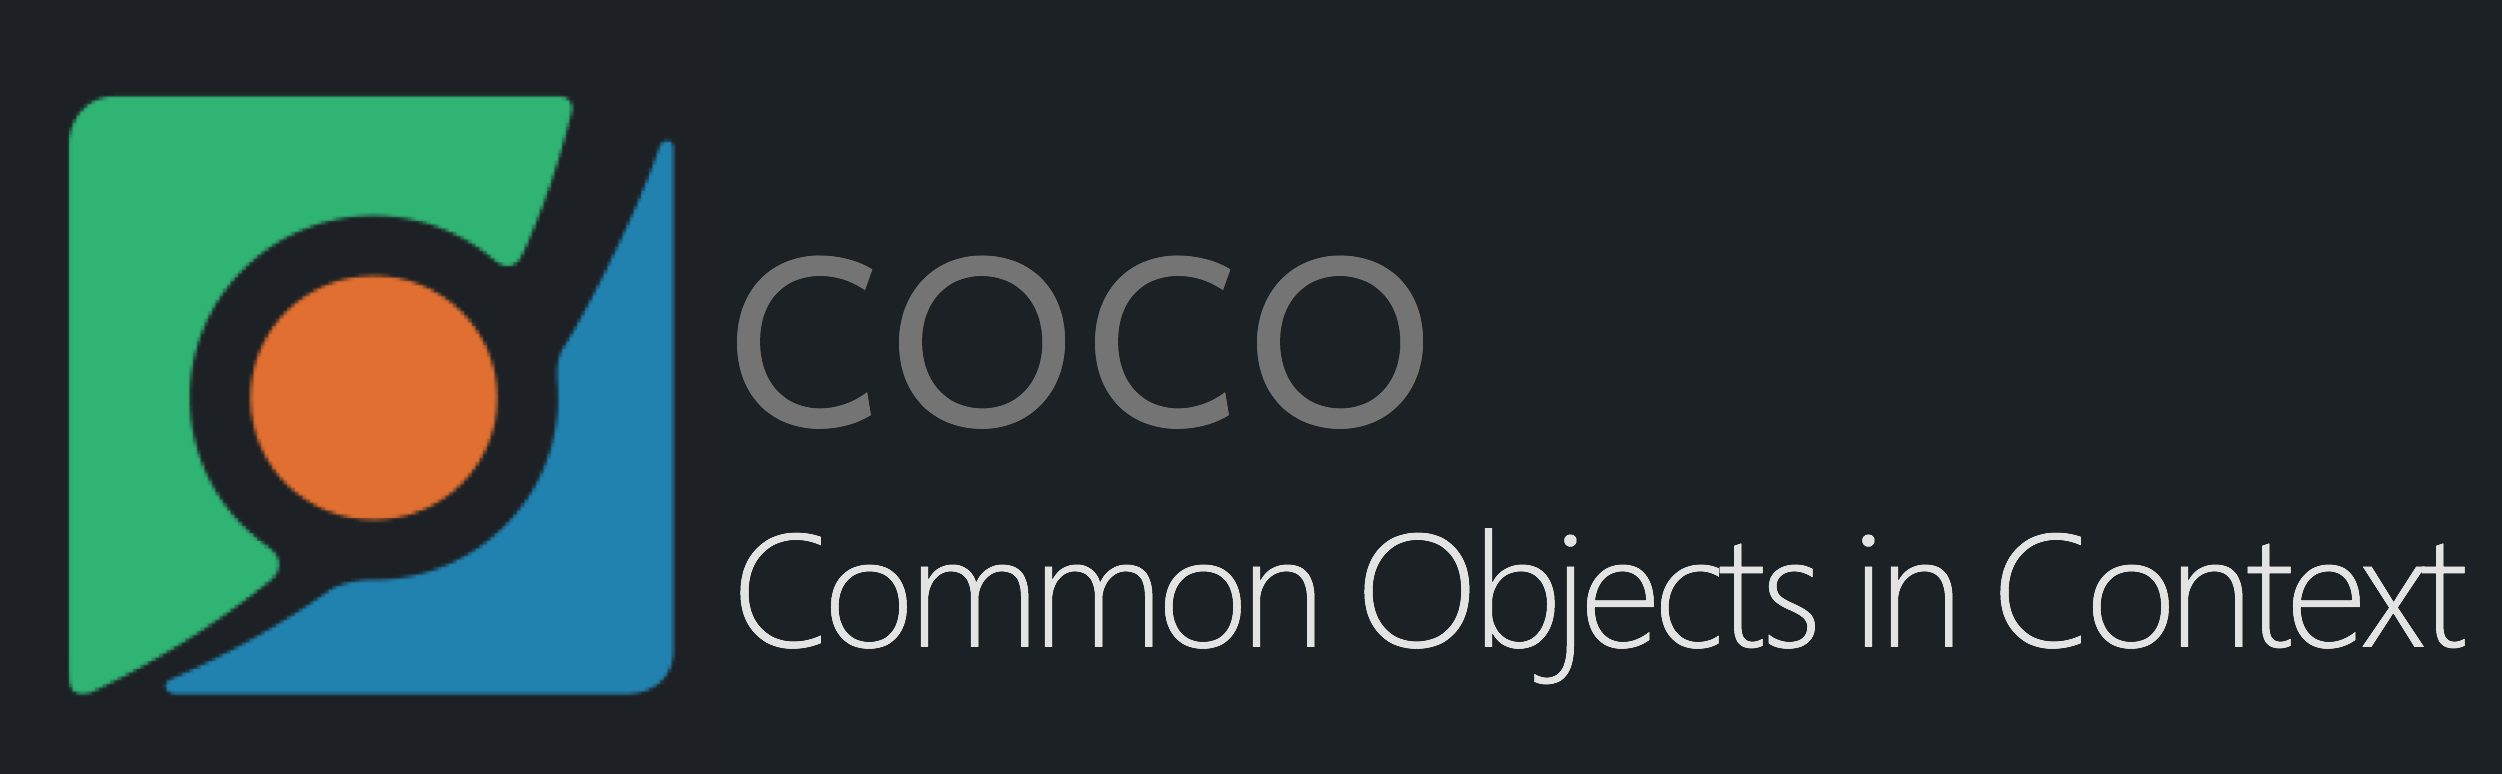

In [ ]:
# Diretório no Google Drive
gdrive_coco_path = '/content/drive/MyDrive/COCO'

# Crie as pastas se ainda não existirem
!mkdir -p {gdrive_coco_path}


In [ ]:
# Baixar imagens de treino
!wget http://images.cocodataset.org/zips/train2017.zip -P {gdrive_coco_path}
!unzip {gdrive_coco_path}/train2017.zip -d {gdrive_coco_path}

# Baixar imagens de validação
!wget http://images.cocodataset.org/zips/val2017.zip -P {gdrive_coco_path}
!unzip {gdrive_coco_path}/val2017.zip -d {gdrive_coco_path}

# Baixar anotações
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {gdrive_coco_path}
!unzip {gdrive_coco_path}/annotations_trainval2017.zip -d {gdrive_coco_path}


# Pytorch - DataLoader

In [ ]:
!lscpu | grep 'CPU(s)'

CPU(s):                               8
On-line CPU(s) list:                  0-7
NUMA node0 CPU(s):                    0-7


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

num_workers = 8 # Definir num_workers = número de CPUs

# Configurações do COCO Dataset
gdrive_coco_path = "/content/drive/MyDrive/COCO"
train_dir = f"{gdrive_coco_path}/train2017"
val_dir = f"{gdrive_coco_path}/val2017"
annotations_train = f"{gdrive_coco_path}/annotations/instances_train2017.json"
annotations_val = f"{gdrive_coco_path}/annotations/instances_val2017.json"

# Transformação para imagens
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensiona para 128x128
    transforms.ToTensor()  # Converte para tensor
])

# Carregar o Dataset COCO
train_dataset = datasets.CocoDetection(
    root=train_dir,
    annFile=annotations_train,
    transform=transform
)

val_dataset = datasets.CocoDetection(
    root=val_dir,
    annFile=annotations_val,
    transform=transform
)

# Função de collate personalizada
def collate_fn(batch):
    # Separe imagens e targets do batch
    images, targets = zip(*batch)

    # Converta as imagens em um único tensor
    images = torch.stack(images, dim=0)

    # Targets permanecem como listas (não combinamos em tensor)
    return images, targets

# Configurar DataLoader com collate_fn
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn, num_workers=num_workers, pin_memory=True)

# Imprimindo informações sobre os datasets
print(f"Número de imagens no conjunto de treino: {len(train_dataset)}")
print(f"Número de imagens no conjunto de validação: {len(val_dataset)}")


loading annotations into memory...
Done (t=16.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
Número de imagens no conjunto de treino: 118287
Número de imagens no conjunto de validação: 5000


## Mostrar um exemplo

Anotações para esta imagem:
Categoria: 24, Caixa delimitadora: [0.96, 20.06, 441.23, 379.15]


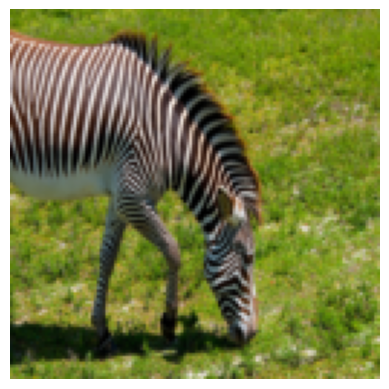

In [ ]:
# Função para exibir imagens com anotações
def show_coco_sample(data, idx=0):
    img, targets = data[idx]

    # Convertendo tensor para imagem
    img = img.permute(1, 2, 0)  # Reorganizar canais para HWC
    plt.imshow(img)
    plt.axis('off')

    # Mostrando as anotações
    print("Anotações para esta imagem:")
    for annotation in targets:
        category_id = annotation['category_id']
        bbox = annotation['bbox']
        print(f"Categoria: {category_id}, Caixa delimitadora: {bbox}")

    plt.show()

# Exibir um exemplo do dataset
show_coco_sample(train_dataset, idx=3)


# Definindo a CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Definição da CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=91):  # COCO tem 91 categorias
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)  # Ajuste para imagem 128x128
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)  # Achatar o tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Inicializar a rede
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=91).to(device)  # 91 classes do COCO


## Função de treinamento e validação

In [ ]:
# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Função de treinamento
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, targets in train_loader:
            # Enviar imagens ao dispositivo
            images = images.to(device)

            # Extrair o primeiro rótulo de cada imagem
            labels = torch.tensor([t[0]['category_id'] if len(t) > 0 else 0 for t in targets]).to(device)

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward e cálculo da perda
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Validar o modelo após cada época
        validate_model(model, val_loader)

# Função para validar o modelo
def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)

            # Extrair o primeiro rótulo de cada imagem
            labels = torch.tensor([t[0]['category_id'] if len(t) > 0 else 0 for t in targets]).to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")

## Salvar modelo

In [ ]:
# Salvar os pesos do modelo treinado
def save_model():
  #torch.save(model.state_dict(), f"{gdrive_coco_path}/coco_cnn_model.pth")
  torch.save(model, f"{gdrive_coco_path}/coco_cnn_full_model.pth")
  print("Modelo salvo como coco_cnn_full_model.pth")


## Treinar modelo

Epoch: 1, Loss: 3.3197, Accuracy: 21.44%

Epoch: 2, Loss: 2.9961, Accuracy: 24.74%

Epoch: 3, Loss: 2.7631, Accuracy: 26.50%

Epoch: 4, Loss: 2.5388, Accuracy: 27.50%

Epoch: 5, Loss: 2.2605, Accuracy: 26.58%

Epoch: 6, Loss: 1.9143, Accuracy: 24.48%

Epoch: 7, Loss: 1.5077, Accuracy: 22.10%

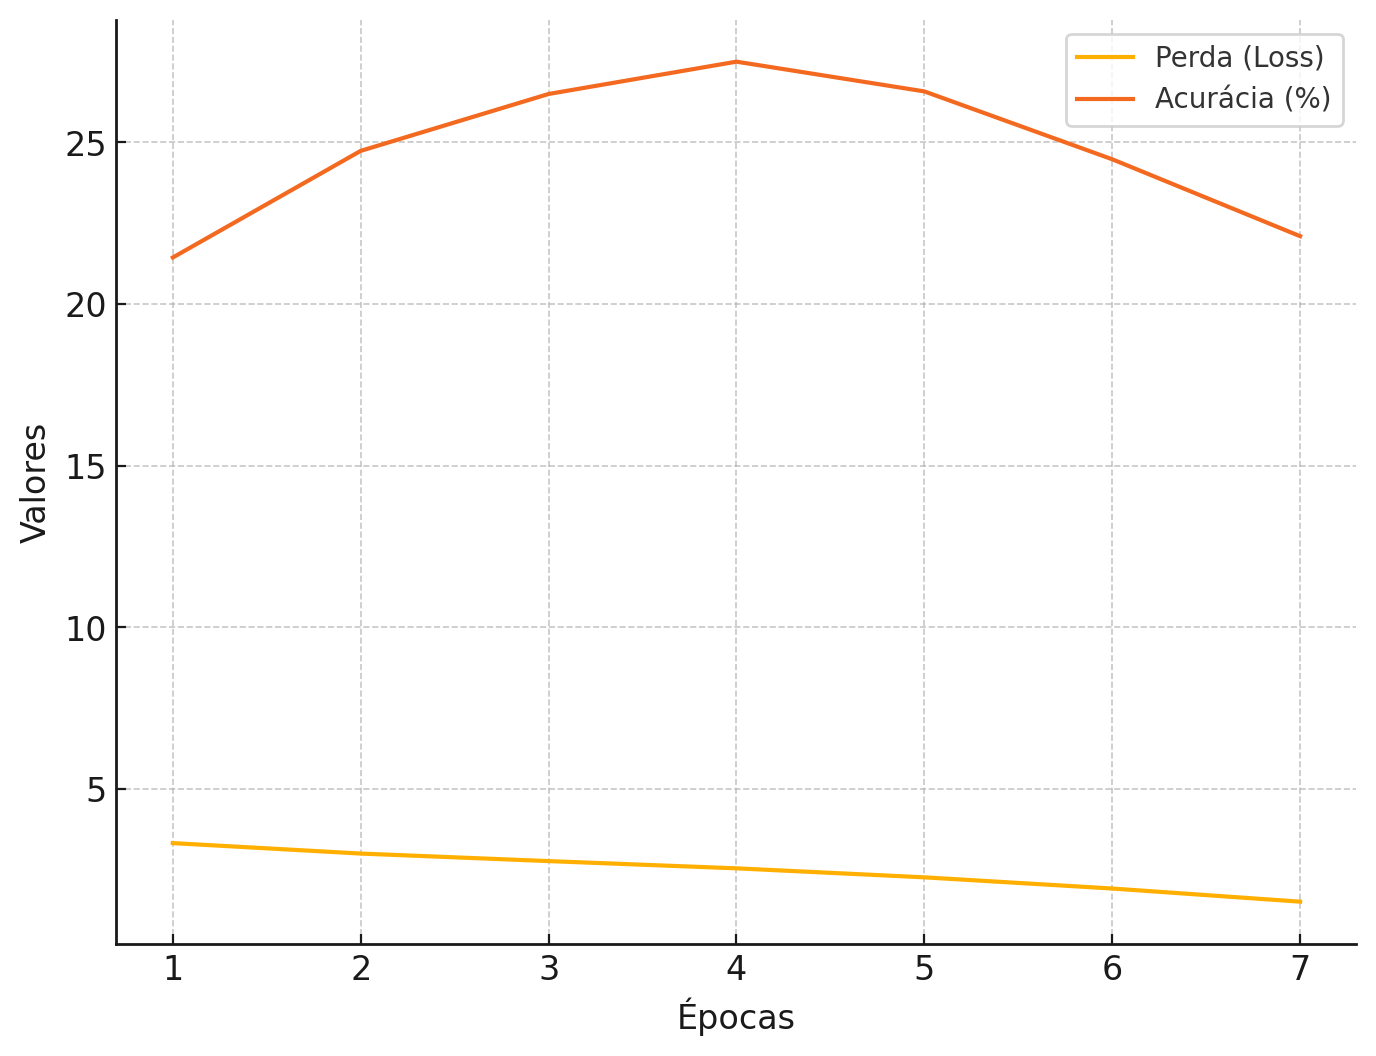

In [76]:
# Treinamento da CNN
train_model(model, train_loader, val_loader, epochs=5)

save_model()

Epoch [1/5], Loss: 2.7631
Accuracy: 26.50%
Epoch [2/5], Loss: 2.5388
Accuracy: 27.50%
Epoch [3/5], Loss: 2.2605
Accuracy: 26.58%
Epoch [4/5], Loss: 1.9143
Accuracy: 24.48%
Epoch [5/5], Loss: 1.5077
Accuracy: 22.10%
Modelo salvo como coco_cnn_full_model.pth


## Abrir modelo

In [ ]:
def load_model():
  # Recrie a arquitetura do modelo
  #model = SimpleCNN(num_classes=91).to(device)

  # Carregue os pesos salvos
  model = torch.load(f"{gdrive_coco_path}/coco_cnn_full_model.pth")
  #model.load_state_dict(torch.load(f"{gdrive_coco_path}/coco_cnn_model.pth", weights_only=True))

  print("Modelo carregado.")

load_model()

Modelo carregado.


# Avaliar modelo

In [77]:
import random

# Função para calcular a métrica final (acurácia) e armazenar logits
def evaluate_model(model, val_loader):
    model.eval()  # Modo de avaliação
    correct = 0
    total = 0
    predictions = []
    logits_list = []  # Para armazenar os tensores de saída completos

    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)

            # Verifique se há anotações em cada imagem
            labels = []
            for t in targets:
                if len(t) > 0:  # Se houver anotações
                    labels.append(t[0]['category_id'])
                else:  # Se não houver anotações, atribua uma categoria padrão (ex.: 0)
                    labels.append(0)

            labels = torch.tensor(labels).to(device)
            outputs = model(images)  # Saída completa do modelo: [batch_size, 91]
            logits_list.append(outputs.cpu())  # Armazenar os logits para análise

            # Predição com base na maior probabilidade
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Armazena exemplos para visualização
            predictions.append((images.cpu(), labels.cpu(), predicted.cpu()))

    accuracy = 100 * correct / total
    print(f"Acurácia Final no Conjunto de Validação: {accuracy:.2f}%")
    return predictions, logits_list

predictions, logits_list = evaluate_model(model, val_loader)


Acurácia Final no Conjunto de Validação: 22.10%


In [78]:
import torch
import matplotlib.pyplot as plt

# Função para retornar imagens onde predomina o rótulo especificado
def filter_images_by_label(predictions, logits_list, label=1):
    filtered_images = []

    for i, (images, labels, predicted) in enumerate(predictions):
        # Logits correspondentes ao lote atual
        logits = logits_list[i]

        for j in range(len(images)):
            # Probabilidades do modelo para a imagem atual
            probabilities = torch.softmax(logits[j], dim=0)

            # Verificar se o rótulo predominante (predicted[j]) é igual ao label
            if predicted[j].item() == label:
                filtered_images.append({
                    "image": images[j],
                    "label": labels[j].item(),
                    "predicted": predicted[j].item(),
                    "probability": probabilities[label].item()
                })

    return filtered_images


Número de imagens onde predomina o label: 1267


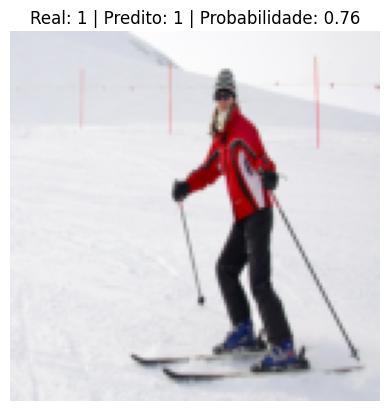

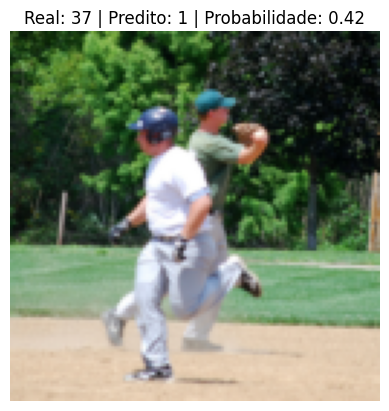

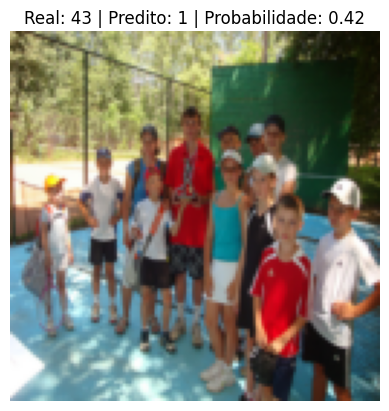

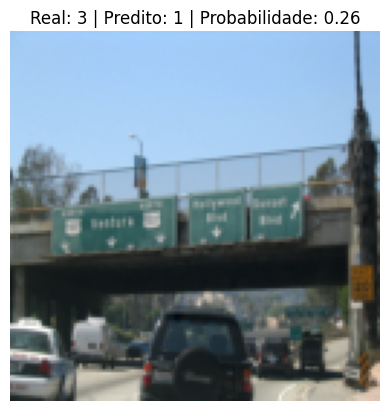

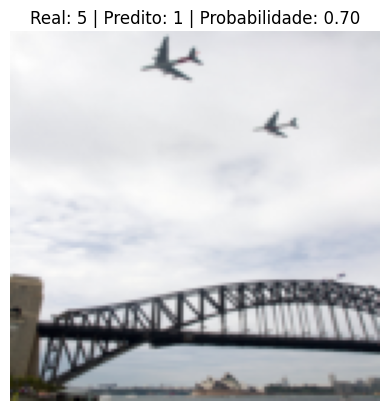

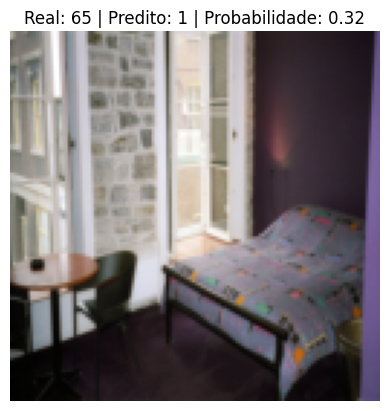

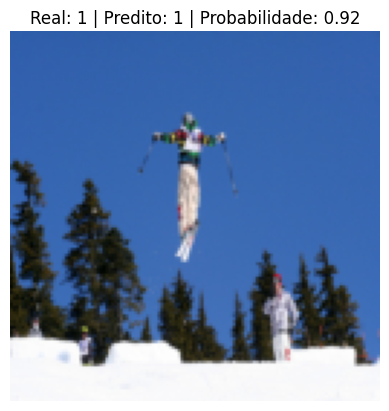

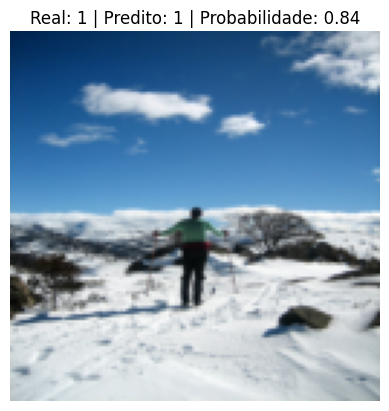

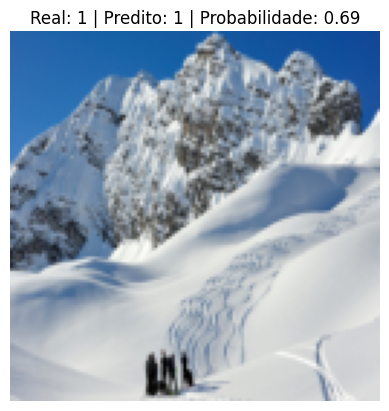

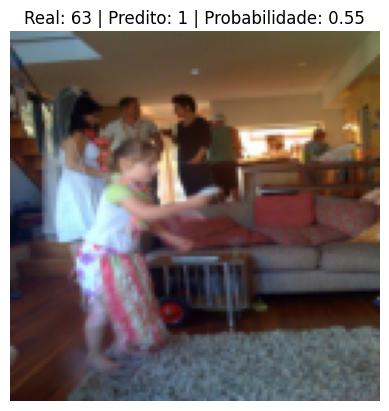

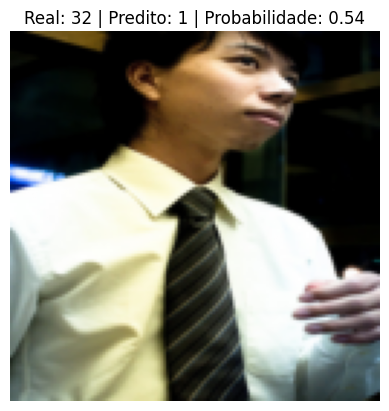

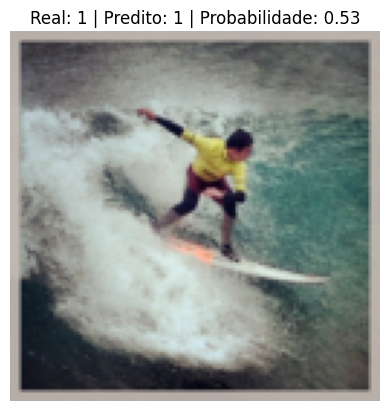

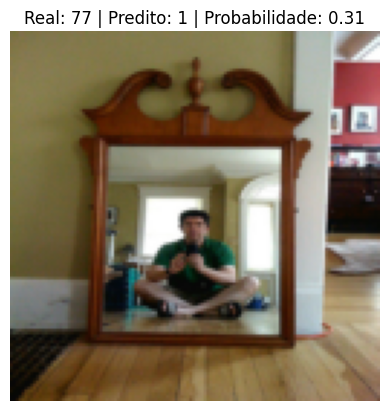

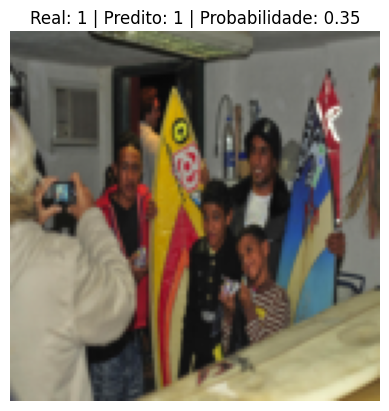

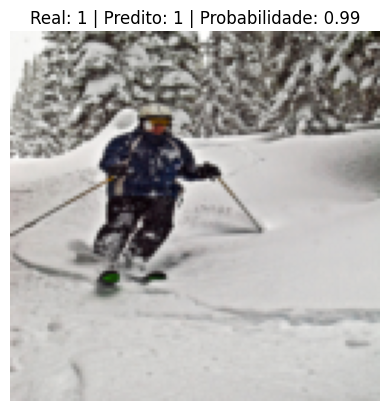

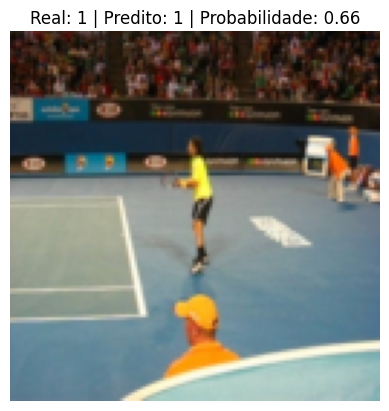

In [79]:
# Filtrar imagens onde o label predominante é "1" (humano)
human_images = filter_images_by_label(predictions, logits_list, label=1)

# Número de imagens filtradas
print(f"Número de imagens onde predomina o label: {len(human_images)}")

# Exemplo: Mostrar a primeiras 16 imagem filtrada
if human_images:
  for i in range(min(len(human_images),16)):
    img = human_images[i]["image"].permute(1, 2, 0).numpy()  # Converter tensor para imagem
    img = (img - img.min()) / (img.max() - img.min())  # Normalizar para [0, 1]
    plt.imshow(img)
    plt.title(f"Real: {human_images[i]['label']} | Predito: {human_images[i]['predicted']} | Probabilidade: {human_images[i]['probability']:.2f}")
    plt.axis('off')
    plt.show()
